##### <span style="color:#483D8B; font-weight:bold;">Import Libraries</span>

In [2]:
!pip install tweet-preprocessor
!pip install pyspellchecker
!pip install symspellpy

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import string
import re
import preprocessor as p
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from symspellpy.symspellpy import SymSpell, Verbosity

##### <span style="color:#483D8B; font-weight:bold;">Import Dataset</span>

In [6]:
path = r"C:\Users\User\Desktop\Ironhack_DA\Final-project-hate-speech-detection-with-NLP\Dataset-Hate-Speech-Detection.csv"

In [7]:
df = pd.read_csv(path, low_memory=False)

In [8]:
df

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


Class explanation:

- 0 - Hate Speech
- 1 - Offensive Language
- 2 - Neither/Neutral content

In [10]:
df.shape

(24783, 2)

In [11]:
df.reset_index(drop=True, inplace=True)
df.index = df.index + 0

In [12]:
df.head(5)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


In [14]:
df.isnull().sum()

class    0
tweet    0
dtype: int64

NOTE: no null values & consistent datatypes

##### <span style="color:#483D8B; font-weight:bold;">Cleaning tweet column</span>

In [17]:
from IPython.display import display
pd.set_option('display.max_colwidth', None)

In [18]:
display(df.iloc[:10, :2])

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;
5,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! &#128514;&#128514;&#128514;"""
6,1,"!!!!!!""@__BrighterDays: I can not just sit up and HATE on another bitch .. I got too much shit going on!"""
7,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of you big bitches coming for us skinny girls!!&#8221;
8,1,""" &amp; you might not get ya bitch back &amp; thats that """
9,1,""" @rhythmixx_ :hobbies include: fighting Mariam""\n\nbitch"


In [19]:
df[df['class'] == 0]

,class,tweet
85,0,"""@Blackman38Tide: @WhaleLookyHere @HowdyDowdy11 queer"" gaywad"
89,0,"""@CB_Baby24: @white_thunduh alsarabsss"" hes a beaner smh you can tell hes a mexican"
110,0,"""@DevilGrimz: @VigxRArts you're fucking gay, blacklisted hoe"" Holding out for #TehGodClan anyway http://t.co/xUCcwoetmn"
184,0,"""@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPLE https://t.co/RNvD2nLCDR"" This is why there's black people and niggers"
202,0,"""@NoChillPaz: ""At least I'm not a nigger"" http://t.co/RGJa7CfoiT""\n\nLmfao"
...,...,...
24576,0,this guy is the biggest faggot omfg
24685,0,"which one of these names is more offensive kike, wop, kraut, wetback jigaboo, towelhead, gook, or redskin."
24751,0,you a pussy ass nigga and I know it nigga.
24776,0,you're all niggers


In [20]:
df.groupby('class').nunique()

,tweet
class,
0,1430
1,19190
2,4163


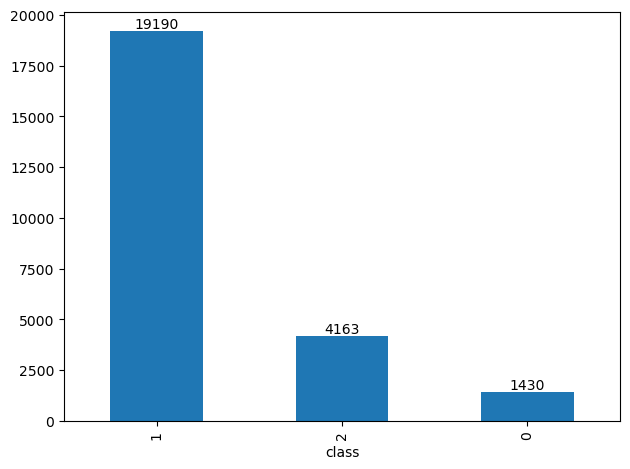

In [21]:
class_count = df['class'].value_counts()

ax = class_count.plot(kind='bar')

for i, value in enumerate(class_count):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [22]:
display(df.iloc[:5, :2])

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;


In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

df['tweet'].lower() #lower case
punc_to_remove = string.punctuations
df['tweet'].translate(str.maketrans('', '', PUNCT_TO_REMOVE))
" ".join(df['tweet'].split())
contractions.fix(df['tweet'])



In [25]:
#df.tweet.str.lower(inplace = True)

#df['tweet'].replace(string.punctuation,'')

#def cleaned_tweet(text):
    # Remove punctuation
    #text = ''.join(char for char in text if char not in string.punctuation)
    #return text.lower()  # Optional: lowercasing

# Apply the cleaning function to the 'tweet' column
#df['tweet'] = df['tweet'].apply(cleaned_tweet)

In [45]:
max_edit_distance_dictionary = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

dictionary_path = "frequency_dictionary_en_82_765.txt"  # path to the downloaded dictionary
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI)

stop_words = set(stopwords.words('english'))
punctuation = string.punctuation
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

def correct_spelling_symspell(text):
    corrected_words = []
    for word in text.split():
        # Skip short words and stopwords to speed up
        if len(word) < 3 or word in stop_words:
            corrected_words.append(word)
            continue
        
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        if suggestions:
            corrected_words.append(suggestions[0].term)
        else:
            corrected_words.append(word)
    return " ".join(corrected_words)

def clean_tweet(text):
    text = p.clean(text)
    text = correct_spelling_symspell(text)
    pattern = r'([{}])\1+'.format(re.escape(punctuation))
    text = re.sub(pattern, r'\1', text)
    tokens = tokenizer.tokenize(text)
    words = [w for w in tokens if w not in stop_words]
    return " ".join(words)

df['tweet_cleaned'] = df['tweet'].apply(clean_tweet)

In [65]:
df['tweet_cleaned'] = df['tweet_cleaned'].str.replace(r'!\s*rt\s*:', '', regex=True).str.replace(r"[^\w\s.,!?']", "", regex=True)

In [67]:
df

,class,tweet,tweet_cleaned
0,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,woman complain cleaning house camp man always take trash .
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,boy date cold.tyga bad coffin dat hoe st place
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,! rt dawg ever fuck bitch start cry confused shit
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,look like granny
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,shit hear might true might faker bitch told ya
...,...,...,...
24778,1,"you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;",muthaf lie rights tl trash . mine bible scriptures hymns
24779,2,"you've gone and broke the wrong heart baby, and drove me redneck crazy",gone broke wrong heart baby drove redneck crazy
24780,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again,young buck wanna eat ! . dat nigga like int fucking dis
24781,1,youu got wild bitches tellin you lies,got wild bitches telling lies


##### <span style="color:#483D8B; font-weight:bold;">Model bulding</span>